In [1]:
import nbsetup
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ergodicpy as ep
import scipy as sp
from scipy.stats import chi2_contingency

SAVE_FIGURES = False
x_points = 20

# Code for plots - analysis below

In [2]:
def rn(hists):
    """ Row normalize """
    hists = np.array(hists)
    return (hists/hists.sum(axis=1)[:, np.newaxis])
    
def grid(rs):
    return [(0, 0), (1, int(len(rs)/2)), (2, -1)]
    
def plot_hists(func, xs, hs, hue_label='h'):
    """ Plots the heatmaps """
    fig, axes = plt.subplots(3, 3, figsize=(10,10))
    for ix, x in grid(xs):
        for ih, h in grid(hs):
            hists = func(xs[x], hs[h])
            g = sns.heatmap(data=hists, ax=axes[ih][ix])
            g.set_title("x=%s, %s=%s" % (xs[x], hue_label, hs[h]))
    
    
def plot(data, x='x', hue='hue'):
    """ Plots Chi2 Tau2 """
    d = data[0].copy()
    del d[x]
    del d[hue]
    
    fig, axes = plt.subplots(2, 2, sharex=True, figsize=(10,10))
    df = pd.DataFrame(data)
    
    # chi2
    g = sns.lineplot(data=df, x=x, y='chi2', ax=axes[0][0], hue=hue)
    g.set(title='Chi2', ylabel=None)
    
    g = sns.lineplot(data=df, x=x, y='chi2_p', ax=axes[0][1], hue=hue, legend=False)
    axes[0][1].axhline(y=0.05, color='grey', linestyle='dotted')
    g.set(ylim=(-0.05,1.05), title='Chi2 p-value', ylabel=None)
    
    # tau
    g = sns.lineplot(data=df, x=x, y='tau2', ax=axes[1][0], hue=hue, legend=False)
    g.set(title='Tau2', ylabel=None)
    
    g = sns.lineplot(data=df, x=x, y='tau2_p', ax=axes[1][1], hue=hue, legend=False)
    axes[1][1].axhline(y=0.05, color='grey', linestyle='dotted')
    g.set(ylim=(-0.05,1.05), title='Tau2 p-value', ylabel=None)
    
    return fig

def compare(x_range, hue_range, hist_func, hue_label, name=None, boost=None, hist_plot=True, flat_weights=False):
    data = []
    for hue in hue_range:
        for x in x_range:
            hists = hist_func(x, hue)
            
            # change default weight behaviour
            if flat_weights:
                weights = np.ones(len(hists))
            else:
                weights = None
            
            # analyse
            measures = ep.measures(hists, tau_boost=boost, weights=weights, with_meta=True)
            chi2, p, _, _ = sp.stats.chi2_contingency(hists)

            # store
            data.append({
                'chi2': chi2,
                'chi2_p': p,
                'tau2': measures['tau2'],
                'tau2_p': measures['tau2p'],
                'x': x,
                hue_label : hue,
            })
    
    fig = plot(data, hue=hue_label)
    if SAVE_FIGURES and name is not None:
        fig.savefig("figures/%s.eps" % name)
    
    if hist_plot:
        plot_hists(hist_func, x_range, hue_range, hue_label)

In [3]:
def state_hist_uniform(x, states):
    return rn([
        np.ones(states*2),
        np.concatenate([np.ones(states)*(1-x), np.ones(states)*x]),
    ])*100

# normalised number of observations
# effectively taking a [p,q] state and splitting it into [p/2,p/2,q/2,q/2] etc
print(state_hist_uniform(0.2,1), state_hist_uniform(0.5,1).sum())
print(state_hist_uniform(0.2,2), state_hist_uniform(0.5,2).sum())

[[50. 50.]
 [80. 20.]] 200.0
[[25. 25. 25. 25.]
 [40. 40. 10. 10.]] 200.0


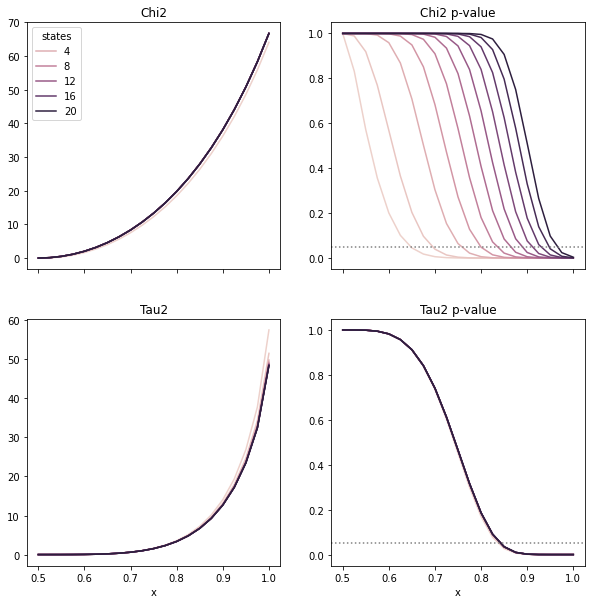

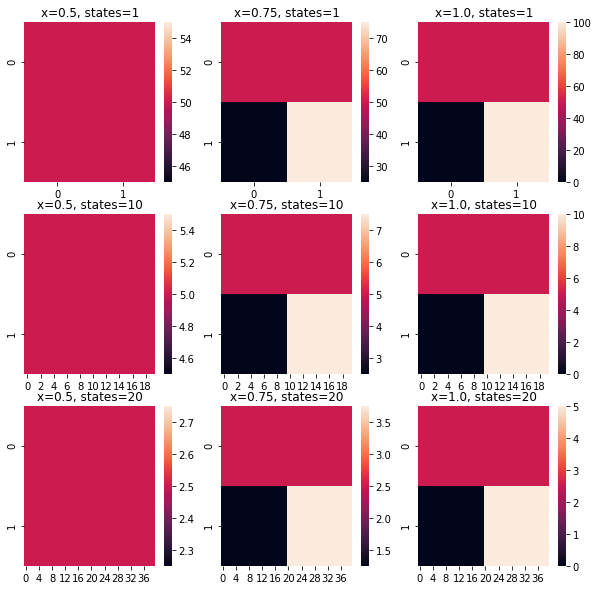

In [4]:
compare(ep.binspace(0.5,1.0,x_points), ep.binint(1,20,10), state_hist_uniform, 'states')

# ############

In [6]:
def state_hist_uniform_increment(x, states):
    return rn([
        np.ones(states*2),
        np.concatenate([np.ones(states)*(1-x), np.ones(states)*x]),
    ])*10*states

print(state_hist_uniform_increment(0.1,2), state_hist_uniform_increment(0.1,2).sum(axis=1))
print(state_hist_uniform_increment(0.1,1), state_hist_uniform_increment(0.1,1).sum(axis=1))

[[5. 5. 5. 5.]
 [9. 9. 1. 1.]] [20. 20.]
[[5. 5.]
 [9. 1.]] [10. 10.]


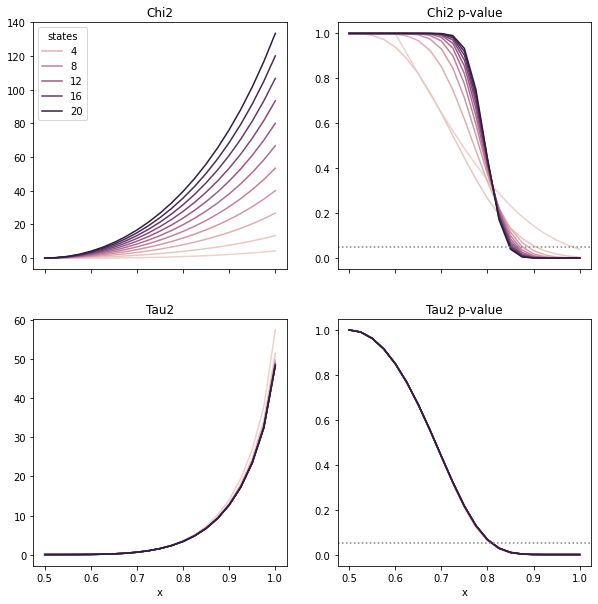

In [7]:
compare(ep.binspace(0.5,1.0,x_points), ep.binint(1,20,10), state_hist_uniform_increment, 'states', hist_plot=False)

## Linear additions

Similarly for linear additions we find

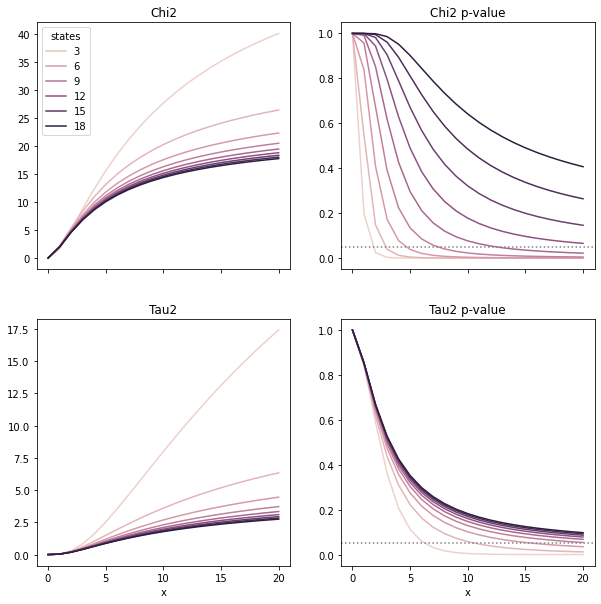

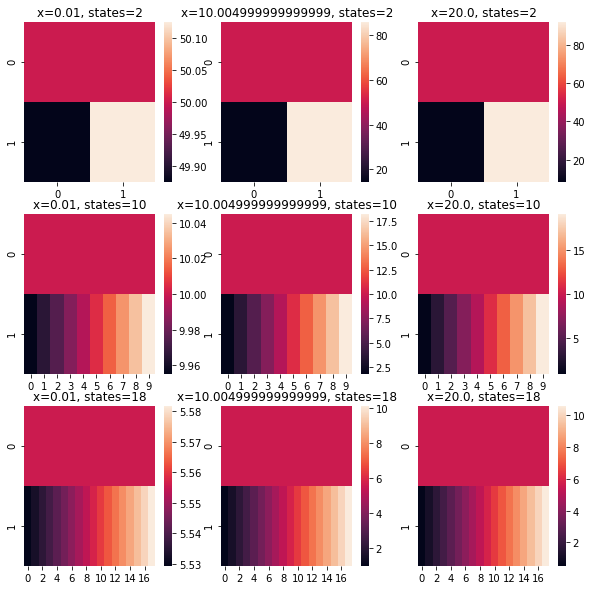

In [15]:
compare(ep.binspace(0.01,20.0,x_points), range(2,20,2), lambda x,h: rn([np.ones(h), [1+x*k/h for k in range(h)]])*100, 'states')

# Weights for observations

- Chi2 has a weighting mechanism built in as it uses raw frequency data
- Tau2 uses weights, which is similar to adjusting the frequency of a particular row
- The default weights are the sum of the observations for that ensemble row (N_k) by the total observations across all ensembles (N_k/N)

In [16]:
def weighted_hist(x, h):
    hists = np.array([[h,h],[1+x,1]]) # just focus on absolute difference between ensembles
    hists /= hists.sum() # normalise to account for obs count differences
    return hists*80 # have to multiply by a decent obs count as chi2 sensitive to absolute obs

def weighted_hist_not_norm(x, h):
    hists = np.array([[h,h],[1+x,1]])
    return hists*10

print(weighted_hist(0.1,10))
print(weighted_hist_not_norm(0.1,10))

[[36.19909502 36.19909502]
 [ 3.98190045  3.6199095 ]]
[[100. 100.]
 [ 11.  10.]]


- Here Chi2 & Tau2 behave similarly
- Here we compare histograms with an increasing difference in the absolute counts across ensmebles
- Meaning the flat ensemble becomes more dominant
- In reality this could be because either that ensemble is easier to get data for therefore the absolute counts are higher or it could be biases in sampling etc
- Chi2 & Tau2 (by default) take these differences into account in the same way, assuming that ensembles with smaller absolute counts exist less in the world and therefore contribute to the heterogenity of the system less also

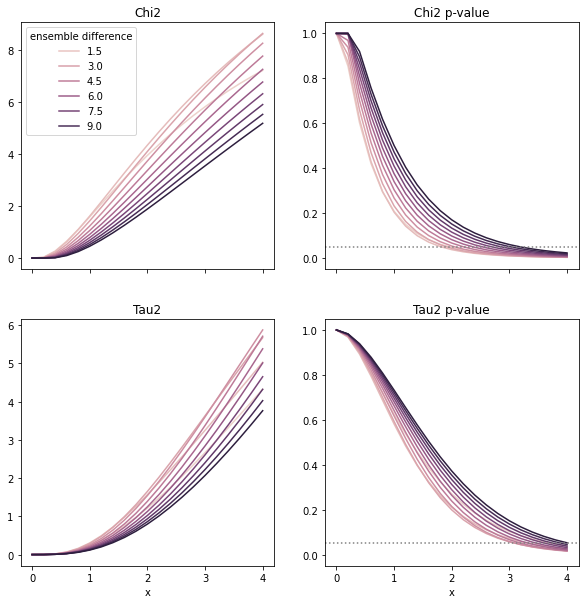

In [17]:
compare(ep.binspace(0.001,4,x_points), ep.binspace(1,10,10), weighted_hist, 'ensemble difference', hist_plot=False)

However, with Tau2 this assumed behaviour can be turned off by setting the weights to all be equal

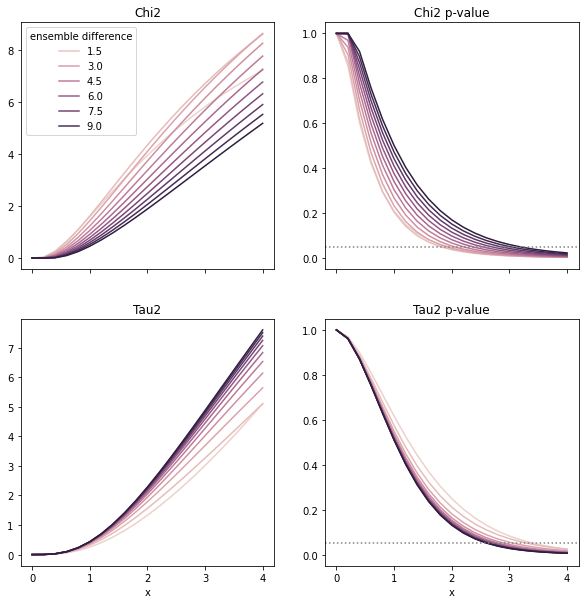

In [18]:
compare(ep.binspace(0.001,4,x_points), ep.binspace(1,10,10), weighted_hist, 'ensemble difference', flat_weights=True, hist_plot=False)

Interestingly, you can also "turn off" this behaviour with Chi2 also. In the first example we normalise the total count of all observations, because Chi2 is sensitive to the total number of observations. However, if we no longer do this, the increase in the number of total observations cancels out the differences between ensembles.

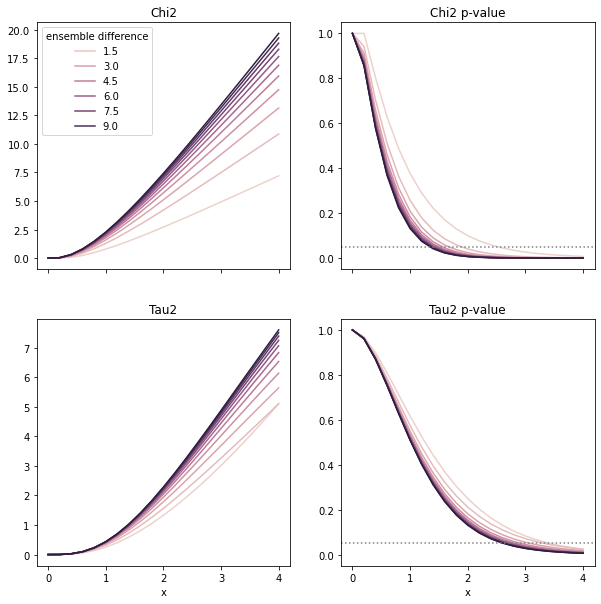

In [19]:
compare(ep.binspace(0.001,4,x_points), ep.binspace(1,10,10), weighted_hist_not_norm, 'ensemble difference', flat_weights=True, hist_plot=False)

This can be thought of conceptually as if you have an ensemble (A) with (2x) the observations as (B) with (1x), you could see this as three ensembles (Ai, Aii, B) each with equal observations. Since in this case, we would see a single outlier ensemble as making the system less complex it is appropriate to weight in this way.